##  Part 4: Faster, more efficient data processing

Let's combine Python and Julia:

In [1]:
from juliacall import Main as jl

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
%load_ext juliacall

In [3]:
%%julia

using Pkg
Pkg.add("UnROOT")
using UnROOT
using AwkwardArray

   Resolving package versions...
  No Changes to `~/anaconda3/envs/julia_hep_2024/julia_env/Project.toml`
  No Changes to `~/anaconda3/envs/julia_hep_2024/julia_env/Manifest.toml`


In [4]:
tree = jl.Main.ROOTFile("./data/SMHiggsToZZTo4L.root")

In [5]:
tree

ROOTFile with 1 entry and 18 streamers.
./data/SMHiggsToZZTo4L.root
└─ Events (TTree)
   ├─ "run"
   ├─ "luminosityBlock"
   ├─ "event"
   ├─ "⋮"
   ├─ "Electron_dzErr"
   ├─ "MET_pt"
   └─ "MET_phi"


In [6]:
events = jl.Main.LazyTree(tree, "Events")

In [7]:
events

 Row │ Electron_mass    nElectron  luminosityBlock  nMuon   Electron_phi     M ⋯
     │ SubArray{Float3  UInt32     UInt32           UInt32  SubArray{Float3  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
 1   │ []               0          156              3       []               - ⋯
 2   │ [0.00544,        4          156              0       [0.134, -1       2 ⋯
 3   │ [-0.00609,       2          156              0       [2.18, 1.6       - ⋯
 4   │ [-0.00123]       1          156              7       [-0.643]         - ⋯
 5   │ [0.0117, 0       4          156              0       [1.01, -1.       1 ⋯
 6   │ [-0.00183]       1          156              2       [-0.497]         - ⋯
 7   │ [-0.00183]       1          156              1       [-1.47]          - ⋯
 8   │ [-0.00216]       1          156              0       [-0.633]         - ⋯
 9   │ [-0.0128,        4          156              0       [2.79, -2.       - ⋯
 10  │ []               0   

In [8]:
jl.events = events

In [9]:
%%julia

first(events.Muon_charge, 4)

4-element Vector{Vector{Int32}}:
 [1, -1, 1]
 []
 []
 [1, -1, -1, 1, -1, -1, 1]

In [10]:
%%julia

using LorentzVectorHEP
one_event = first(events);

# destruct syntax sugar
(; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = one_event

muons = LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass)


3-element Vector{LorentzVectorCyl{Float32}}:
 LorentzVectorCyl{Float32}(pt=63.04387, eta=-0.7186822, phi=2.968006, mass=0.10565837)
 LorentzVectorCyl{Float32}(pt=38.120346, eta=-0.879457, phi=-1.032475, mass=0.10565837)
 LorentzVectorCyl{Float32}(pt=4.0486875, eta=-0.32076442, phi=1.0385035, mass=0.10565837)

In [11]:
%%julia

function main_looper(events)
    array = AwkwardArray.PrimitiveArray{Float64}()
    for evt in events

        (; Muon_charge) = evt
        if length(Muon_charge) != 4
            continue
        end
        sum(Muon_charge) != 0 && continue # shortcut if-else
        
        (; Muon_pt, Muon_eta, Muon_phi, Muon_mass) = evt
        higgs_4vector = sum(LorentzVectorCyl.(Muon_pt, Muon_eta, Muon_phi, Muon_mass))
        higgs_mass = mass(higgs_4vector)
        
        push!(array, higgs_mass)
    end
    
    return array
end

main_looper (generic function with 1 method)

In [12]:
%%julia

array = @time main_looper(events)

  0.398615 seconds (398.56 k allocations: 77.554 MiB, 3.85% gc time, 83.91% compilation time)


20525-element AwkwardArray.PrimitiveArray{Float64, Vector{Float64}, :default}:
 125.12303161621094
 123.90653991699219
 124.15757751464844
 122.6549301147461
 125.26071166992188
 124.77593994140625
 124.20553588867188
 124.42249298095703
 110.03680419921875
 124.46846008300781
   ⋮
 127.15644836425781
  70.50875091552734
 127.02130126953125
 124.43931579589844
 125.2630615234375
  83.22042083740234
 124.33792114257812
 114.71159362792969
 117.13601684570312

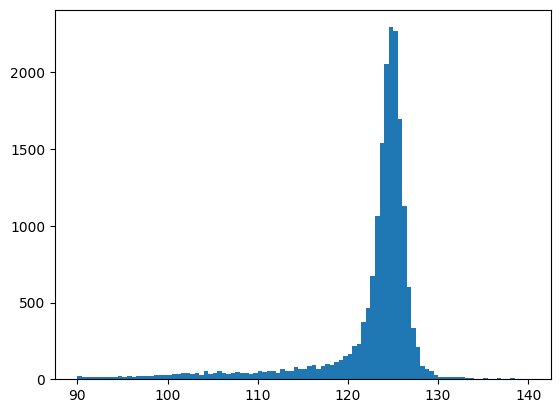

In [13]:
import matplotlib.pyplot as plt
plt.hist(jl.array, bins=100, range=(90, 140));